In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

#### Example: Credit card default prediction

- We want to predict whether a customers will default on their credit card debt based on income, monthly balance, and studentness.

- We model a customer defaulting using the **logistic regression model**:
  $$
  y\sim \operatorname{Bernoulli}\big(\texttt{default}\mid p\big),
  $$
  where
  $$
  \log\left(\frac p{1-p}\right) = a + b\,\texttt{income}+c\,\texttt{balance} + d\,\texttt{student}
  $$


#### Interpreting the coefficient of a binary feature in a logistic regression model

- Odds of defaulting:&nbsp;
  $\displaystyle{{o} = \frac{p}{1-p}}$
- From the logistic regression model:

  $$
  \begin{aligned}
  \log\frac{o_{\text{student}}}
  {o_{\text{nonstudent}}} &=
  \log\left(\frac{p_{\text{student}}}{1-p_{\text{student}}}\right) - \log\left(\frac{p_{\text{nonstudent}}}{1-p_{\text{nonstudent}}}\right)\\
  &= \phantom{-}(a + b\,\texttt{income}+c\,\texttt{balance} + d\,(1))\\&\phantom{=}-(a + b\,\texttt{income}+c\,\texttt{balance} + d\,(0))\\
  &= d\\
  \frac{o_{\text{student}}}{o_{\text{nonstudent}}} &= e^{d}\approx 0.54
  \end{aligned}
  $$

- **_The odds of a student defaulting are roughly half those of a nonstudent with comparable income and balance._**


In [2]:
df = pd.read_csv("data/Default.csv")
df

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
...,...,...,...,...
9995,0,0,711.555020,52992.378914
9996,0,0,757.962918,19660.721768
9997,0,0,845.411989,58636.156984
9998,0,0,1569.009053,36669.112365


In [10]:
X = df[["income", "balance", "student"]]
y = df["default"]
model = LogisticRegression()
model.fit(X, y)

a = model.intercept_
b, c, d = model.coef_.squeeze()

assert np.exp(d).round(2) == 0.54  # See "interpretation" markdown cell.

In [26]:
p = model.predict_proba(X)[:, 1]
all(model.predict(X) == (p >= 0.5))

True

In [30]:
x = pd.DataFrame(
    {
        "income": [10000, 10000],
        "balance": [2000, 2000],
        "student": [1, 0],
    }
)

model.predict(x), model.predict_proba(x)[:, 1]

(array([0, 1]), array([0.49661381, 0.64543196]))

In [ ]:
p_student = model.predict_proba(x)[0, 1]
p_nonstudent = model.predict_proba(x)[1, 1]

o_student = p_student / (1 - p_student)
o_nonstudent = p_nonstudent / (1 - p_nonstudent)

assert np.isclose(
    np.log(o_student / o_nonstudent), d
)  # See "interpretation" markdown cell.

- Let's compare risk of default for student versus nonstudent cardholders with incomes of $10000 for a range of balances.

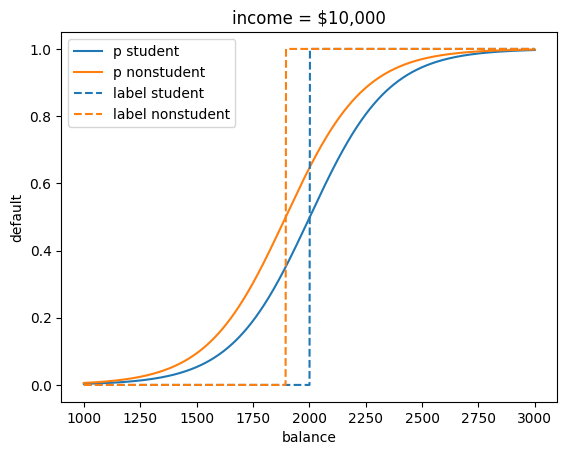

In [ ]:
balance = np.linspace(1000, 3000, 1000)

x_student = pd.DataFrame(
    {
        "income": [10000 for _ in balance],
        "balance": balance,
        "student": [1 for _ in balance],
    }
)

x_nonstudent = pd.DataFrame(
    {
        "income": [10000 for _ in balance],
        "balance": balance,
        "student": [0 for _ in balance],
    }
)

p_student = model.predict_proba(x_student)[:, 1]
p_nonstudent = model.predict_proba(x_nonstudent)[:, 1]

pred_student = model.predict(x_student)
pred_nonstudent = model.predict(x_nonstudent)

plt.plot(balance, p_student, label="p student")
plt.plot(balance, p_nonstudent, label="p nonstudent")

plt.plot(balance, pred_student, "--C0", label="label student")
plt.plot(balance, pred_nonstudent, "--C1", label="label nonstudent")

plt.xlabel("balance")
plt.ylabel("default")

plt.title("income = $10,000")

plt.legend()
plt.show()

In [58]:
Y = (y.to_numpy().reshape(-1, 1) == np.array([[0, 1]])).astype(int)
log_p = model.predict_log_proba(X)

In [62]:
from sklearn.metrics import log_loss

assert np.isclose(
    -np.sum(Y * log_p, axis=1).mean(), log_loss(y, model.predict_proba(X)[:, 1])
)

### Fake data generation

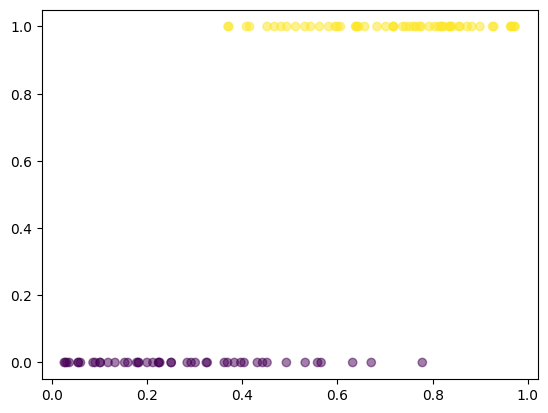

In [83]:
from scipy.special import expit

a = -5
b = 10

rng = np.random.default_rng()


def make_data(n):
    x = rng.uniform(size=n)
    p = expit(a + b * x)
    y = rng.uniform(size=n) < p
    return x, y


x, y = make_data(100)
plt.scatter(x, y, c=y, alpha=0.5)
plt.show()

In [85]:
X = x.reshape(-1, 1)
model = LogisticRegression()
model.fit(X, y)
model.intercept_.item(), model.coef_.item()

(-1.8657396833515218, 4.085605529646678)

In [ ]:
a = np.linspace(-3, 0, 50)
b = np.linspace(2, 6, 50)

A, B = np.meshgrid(a, b)

Z = A + B * x.reshape(-1, 1, 1)

for i in range(100):
    for j in range(50):
        for k in range(50):
            assert np.isclose(Z[i, j, k], A[j, k] + B[j, k] * x[i])
            assert np.isclose(Z[i, j, k], a[k] + b[j] * x[i])

P = expit(Z)